# Novelty Analysis

* Let $\theta_i$ be the output from the block model estimation.
* Let $\theta_i = \theta_i / \sum_j\theta_{ij}$.
* The novelty of combination $h$ is defined as $-\log\sum_k\prod_{i\in h}\theta_{ik}$.

## Workbench

In [1]:
import numpy as np
import scipy.sparse as ssp
import random
from collections import Counter
from scipy.stats import dirichlet, pearsonr, poisson, rankdata, gaussian_kde
import sys
import pickle
import time
from multiprocessing import Pool,cpu_count
import pandas as pd
import itertools
from functools import partial
from sklearn.manifold import MDS,TSNE

In [2]:
%matplotlib inline
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
from matplotlib import cm, ticker
from adjustText import adjust_text
#from bokeh.plotting import figure, output_notebook, show
#output_notebook()

In [3]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print(msg, end='', flush=True)
        self.start_time=time.time()
    def stop(self,msg=''):
        if msg:
            print("{}: {:2f} seconds".format(msg,time.time()-self.start_time), flush=True)
        else:
            print("Elapsed time: {:2f} seconds".format(time.time()-self.start_time), flush=True)
    def check(self):
        return time.time()-self.start_time

tic=Stopwatch()

## Load data

In [4]:
def load_date(filename):
    tic=Stopwatch()
    tic.go("Loading paper dates {} from disk...".format(filename))
    pkl_file = open(filename, 'rb')
    A=pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    tic.stop()
    return A

def load_hypergraph(filename):
    tic=Stopwatch()
    tic.go("Loading file {} from disk...".format(filename))
    pkl_file = open(filename, 'rb')
    (row,col) = pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    A=ssp.coo_matrix((np.ones(len(row),dtype=np.int8),(row,col)),shape=(19916562, max(col)+1),dtype=np.int8)
    tic.stop()
    return A

In [5]:
tic.go('Loading citation data...')
citations=pickle.load(open('../medline/citations.pkl','rb'),encoding='latin1').tocsr()
tic.stop()
# Load hypergraphs
PM=[] # paper by mesh terms
for i in ['chemical','disease','method']:
    PM.append(load_hypergraph('../medline/'+i+'.pkl'))
PM=ssp.hstack(PM).tocsr()
PJ=load_hypergraph('../medline/journals.pkl').tocsr() # paper by journal

paper_dates=load_date('../medline/paper_dates.pkl') # publication date

id2chemical=pickle.load(open('../medline/id2chemical.pkl','rb'),encoding='latin1')
id2disease=pickle.load(open('../medline/id2disease.pkl','rb'),encoding='latin1')
id2method=pickle.load(open('../medline/id2method.pkl','rb'),encoding='latin1')
id2name=np.array(id2chemical+id2disease+id2method)

Loading citation data...

/tmp/ipykernel_465/2009546017.py:2: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  citations=pickle.load(open('../medline/citations.pkl','rb'),encoding='latin1').tocsr()


Elapsed time: 9.723058 seconds
Loading file ../medline/chemical.pkl from disk...Elapsed time: 7.143486 seconds
Loading file ../medline/disease.pkl from disk...Elapsed time: 4.309189 seconds
Loading file ../medline/method.pkl from disk...Elapsed time: 6.328533 seconds
Loading file ../medline/journals.pkl from disk...Elapsed time: 84.955131 seconds
Loading paper dates ../medline/paper_dates.pkl from disk...Elapsed time: 2.522147 seconds


In [6]:
thetas_M,_,times_M=pickle.load(open('../Fitted_Model/block_model_medline_mesh.pkl','rb'))
thetas_J,_,times_J=pickle.load(open('../Fitted_Model/block_model_medline_journal.pkl','rb'))

## Calculation

In [7]:
def get_propensity(x):
    h=G[x,:].nonzero()[1]
    if h.size > 0:
        s=theta[h,:].prod(axis=0).sum()
    else:
        s=np.nan
    return (h.size,s)

In [7]:
print([(times_M==1951).nonzero()[0][0]])

[np.int64(4)]


In [10]:
years=np.arange(1965,2001)
dfs=[]
for t in years:
    papers=(paper_dates==t).nonzero()[0]
    tic.go('Time: {} | Papers: {} | '.format(t,len(papers)))
    df=pd.DataFrame({'ID':papers})
    df['time']=t
    # get content propensity
    theta=thetas_M[(times_M==t).nonzero()[0][0]]
    G=PM
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_propensity, df['ID'])
    a,b=zip(*res)
    df['terms']=a
    df['pM']=b
    # get context novelty
    theta=thetas_J[(times_J==t).nonzero()[0][0]]
    G=PJ
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_propensity, df['ID'])
    a,b=zip(*res)
    df['refs']=a
    df['pJ']=b
    dfs.append(df)
    tic.stop('Time cost')

Time: 1965 | Papers: 154666 | Time cost: 8.765250 seconds
Time: 1966 | Papers: 156711 | Time cost: 8.348016 seconds
Time: 1967 | Papers: 168406 | Time cost: 8.962640 seconds
Time: 1968 | Papers: 184234 | Time cost: 9.758418 seconds
Time: 1969 | Papers: 192312 | Time cost: 10.529804 seconds
Time: 1970 | Papers: 195367 | Time cost: 10.393409 seconds
Time: 1971 | Papers: 199313 | Time cost: 10.539887 seconds
Time: 1972 | Papers: 204058 | Time cost: 10.999472 seconds
Time: 1973 | Papers: 207236 | Time cost: 11.147650 seconds
Time: 1974 | Papers: 210733 | Time cost: 11.428981 seconds
Time: 1975 | Papers: 221837 | Time cost: 11.931665 seconds
Time: 1976 | Papers: 226115 | Time cost: 12.153629 seconds
Time: 1977 | Papers: 232439 | Time cost: 12.607119 seconds
Time: 1978 | Papers: 242206 | Time cost: 12.956378 seconds
Time: 1979 | Papers: 251212 | Time cost: 13.573505 seconds
Time: 1980 | Papers: 249876 | Time cost: 13.434354 seconds
Time: 1981 | Papers: 251146 | Time cost: 13.592483 seconds
T

In [11]:
years=np.arange(1965,2001)
dfs=[]
for t in years:
    papers=(paper_dates==t).nonzero()[0]
    tic.go('Time: {} | Papers: {} | '.format(t,len(papers)))
    df=pd.DataFrame({'ID':papers})
    df['time']=t
    # get content propensity
    theta=thetas_M[(times_M==t).nonzero()[0][0]]
    G=PM
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_propensity, df['ID'])
    a,b=zip(*res)
    df['terms']=a
    df['pM']=b
    # get context novelty
    theta=thetas_J[(times_J==t).nonzero()[0][0]]
    G=PJ
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_propensity, df['ID'])
    a,b=zip(*res)
    df['refs']=a
    df['pJ']=b
    dfs.append(df)
    tic.stop('Time cost')

Time: 1965 | Papers: 154666 | Time cost: 8.183250 seconds
Time: 1966 | Papers: 156711 | Time cost: 8.417357 seconds
Time: 1967 | Papers: 168406 | Time cost: 9.171055 seconds
Time: 1968 | Papers: 184234 | Time cost: 9.910507 seconds
Time: 1969 | Papers: 192312 | Time cost: 10.316463 seconds
Time: 1970 | Papers: 195367 | Time cost: 10.566104 seconds
Time: 1971 | Papers: 199313 | Time cost: 10.697594 seconds
Time: 1972 | Papers: 204058 | Time cost: 11.063666 seconds
Time: 1973 | Papers: 207236 | Time cost: 11.181892 seconds
Time: 1974 | Papers: 210733 | Time cost: 11.418297 seconds
Time: 1975 | Papers: 221837 | Time cost: 11.938323 seconds
Time: 1976 | Papers: 226115 | Time cost: 12.166913 seconds
Time: 1977 | Papers: 232439 | Time cost: 12.600734 seconds
Time: 1978 | Papers: 242206 | Time cost: 13.024673 seconds
Time: 1979 | Papers: 251212 | Time cost: 13.580929 seconds
Time: 1980 | Papers: 249876 | Time cost: 13.723684 seconds
Time: 1981 | Papers: 251146 | Time cost: 13.616397 seconds
T

In [12]:
corrs=[]
corr_p=[]
for df in dfs:
    df2=df[['pM','pJ']].dropna()
    c,p=pearsonr(df2['pM'],df2['pJ'])
    corrs.append(c)
    corr_p.append(p)

In [13]:
corrs=np.array(corrs)
corr_p=np.array(corr_p)
corrs[corr_p>0.05]=0

In [14]:
np.median(corrs),np.mean(corrs),min(corr_p),max(corr_p)

(np.float64(0.0),
 np.float64(0.012175610287967587),
 np.float64(6.466779300238365e-191),
 np.float64(0.9603766179536892))

In [8]:
def get_novelty(x):
    h=G[x,:].nonzero()[1]
    if h.size > 0:
        s=theta[h,:].prod(axis=0).sum()
    else:
        s=np.nan
    return (h.size,s)

In [9]:
years=np.arange(1965,2001)
dfs=[]
for t in years:
    papers=(paper_dates==t+1).nonzero()[0]
    tic.go('Time: {} | Papers: {} | '.format(t+1,len(papers)))
    df=pd.DataFrame({'ID':papers})
    df['time']=t+1
    # get citation counts
    c=citations[papers+1,:].sum(axis=1).A.ravel()
    df['cites']=c
    df['hit']=c>np.percentile(c,90)
    # get content novelty
    theta=thetas_M[(times_M==t).nonzero()[0][0]]
    theta=theta/theta.sum(axis=1).reshape(theta.shape[0],1)
    G=PM
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_novelty, df['ID'])
    a,b=zip(*res)
    df['terms']=a
    df['sM']=b
    # get context novelty
    theta=thetas_J[(times_J==t).nonzero()[0][0]]
    theta=theta/theta.sum(axis=1).reshape(theta.shape[0],1)
    G=PJ
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_novelty, df['ID'])
    a,b=zip(*res)
    df['refs']=a
    df['sJ']=b
    dfs.append(df)
    tic.stop('Time cost')

Time: 1966 | Papers: 156711 | Time cost: 8.991956 seconds
Time: 1967 | Papers: 168406 | Time cost: 9.381230 seconds
Time: 1968 | Papers: 184234 | Time cost: 10.038713 seconds
Time: 1969 | Papers: 192312 | Time cost: 10.736286 seconds
Time: 1970 | Papers: 195367 | Time cost: 10.569571 seconds
Time: 1971 | Papers: 199313 | Time cost: 10.968809 seconds
Time: 1972 | Papers: 204058 | Time cost: 11.254935 seconds
Time: 1973 | Papers: 207236 | Time cost: 11.444404 seconds
Time: 1974 | Papers: 210733 | Time cost: 11.767495 seconds
Time: 1975 | Papers: 221837 | Time cost: 12.240248 seconds
Time: 1976 | Papers: 226115 | Time cost: 12.627643 seconds
Time: 1977 | Papers: 232439 | Time cost: 13.013351 seconds
Time: 1978 | Papers: 242206 | Time cost: 13.367860 seconds
Time: 1979 | Papers: 251212 | Time cost: 13.797402 seconds
Time: 1980 | Papers: 249876 | Time cost: 13.974955 seconds
Time: 1981 | Papers: 251146 | Time cost: 13.627537 seconds
Time: 1982 | Papers: 260583 | Time cost: 14.220349 seconds

### Save results

In [11]:
with open('../Results/novelty_medline_results.pkl','wb') as outfile2:
    pickle.dump([dfs,years],outfile2)

## Results

In [12]:
with open('../Results/novelty_medline_results.pkl','rb') as infile:
     dfs,years=pickle.load(infile)

### Novelty and hit paper

In [13]:
%%time
percentitles=np.linspace(0,100,30)
X_m=[]
Y_m=[]
X_j=[]
Y_j=[]
for t in range(1966,2000):
    i=(years==t).nonzero()[0][0]
    df=dfs[i].loc[dfs[i].terms>1,['sM','hit']].dropna()
    x=-np.log(df.sM)
    xbins,indx=np.unique(np.percentile(x, percentitles), return_index=True)
    H,_=np.histogram(x,xbins)
    H2,_=np.histogram(x[df.hit],xbins)
    y=H2/H
    Y_m.append(y)
    X_m.append((percentitles[indx[1:]]+percentitles[indx[:-1]])/2)
    
    df=dfs[i].loc[dfs[i].refs>1,['sJ','hit']].dropna()
    x=-np.log(df.sJ+1)
    xbins,indx=np.unique(np.percentile(x, percentitles), return_index=True)
    H,_=np.histogram(x,xbins)
    H2,_=np.histogram(x[df.hit],xbins)
    y=H2/H
    Y_j.append(y)
    X_j.append((percentitles[indx[1:]]+percentitles[indx[:-1]])/2)

CPU times: user 1.4 s, sys: 42.1 ms, total: 1.44 s
Wall time: 1.45 s


In [14]:
X_m=np.hstack(X_m)
Y_m=np.hstack(Y_m)
X_j=np.hstack(X_j)
Y_j=np.hstack(Y_j)

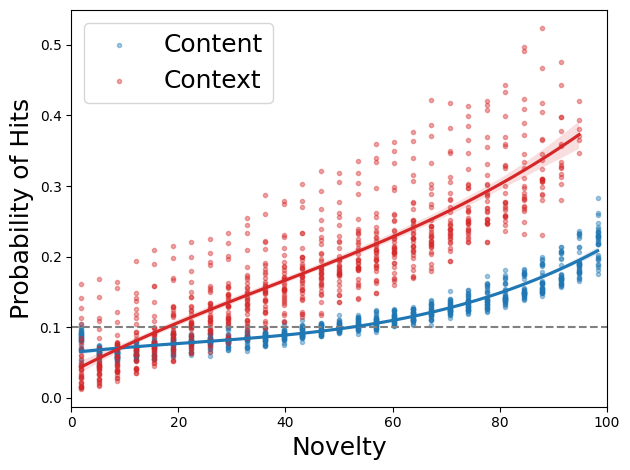

In [15]:
plt.figure()
plt.plot([0,100],[0.1]*2,'--',color='grey');
sns.regplot(x=X_m,y=Y_m,order=3,label='Content',color='C0',marker='.',scatter_kws=dict(alpha=0.4),truncate=True);
sns.regplot(x=X_j,y=Y_j,order=3,label='Context',color='C3',marker='.',scatter_kws=dict(alpha=0.4),truncate=True);
plt.xlabel('Novelty',fontsize=18)
plt.ylabel('Probability of Hits',fontsize=18);
plt.legend(loc='best',fontsize=18);
plt.xlim([0,100]);
plt.tight_layout();

In [58]:
pearsonr(X_m, Y_m)

PearsonRResult(statistic=np.float64(0.15482328145926993), pvalue=np.float64(0.0))

In [17]:
pearsonr(X_j, Y_j)

PearsonRResult(statistic=np.float64(0.876174271473947), pvalue=np.float64(2.7903680591133567e-272))

### Joint novelty and hit papers

In [18]:
def polyfit2d(x, y, z, order=2):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

In [19]:
%%time
xpercentitles=np.linspace(0,100,20)
ypercentitles=np.linspace(0,100,20)
X=[]
Y=[]
Z=[]
for t in range(1966,2000):
    i=(years==t).nonzero()[0][0]
    df=dfs[i].loc[np.bitwise_and(dfs[i].refs>1,dfs[i].terms>1),['sM','sJ','hit']].dropna()
    x=-np.log(df.sM)
    y=-np.log(df.sJ+1)
    xbins,xindx=np.unique(np.percentile(x,xpercentitles),return_index=True)
    ybins,yindx=np.unique(np.percentile(y,ypercentitles),return_index=True)
    H,_,_=np.histogram2d(x,y,[xbins,ybins])
    H2,_,_=np.histogram2d(x[df.hit],y[df.hit],[xbins,ybins])
    z=H2.T/(H.T+1)
    x,y=np.meshgrid(xpercentitles[xindx[:-1]],ypercentitles[yindx[:-1]]);     
    Y.append(y)
    X.append(x)
    Z.append(z)

CPU times: user 933 ms, sys: 16.2 ms, total: 950 ms
Wall time: 951 ms


In [20]:
X=np.vstack(X)
Y=np.vstack(Y)
Z=np.vstack(Z)

In [21]:
m=polyfit2d(X.flatten(), Y.flatten(), Z.flatten(), 4)
xnew, ynew = np.meshgrid(np.linspace(xpercentitles[0],xpercentitles[-2],50), np.linspace(ypercentitles[0],ypercentitles[-2],50))
znew=polyval2d(xnew,ynew,m)

AttributeError: 'Axes3D' object has no attribute 'w_xaxis'

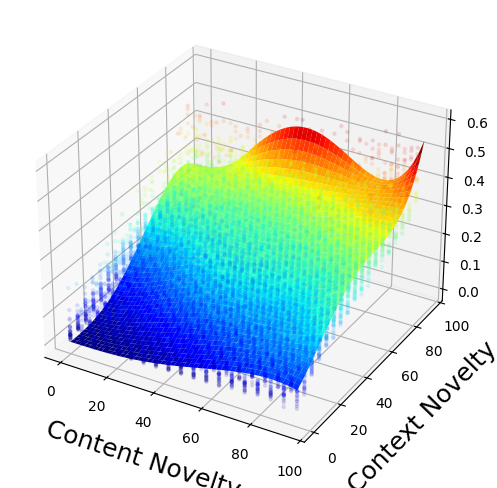

In [22]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.flatten(),Y.flatten(), Z.flatten(), c=Z.flatten(),alpha=0.1,marker='.',cmap='jet');
# ax.contourf(xnew,ynew,znew,50,offset=0.0, cmap='jet');
# ax.plot_surface(xnew,ynew,znew,cmap='jet',alpha=1,rcount=10,ccount=10);
ax.plot_surface(xnew,ynew,znew,cmap='jet',alpha=1);
# ax.view_init(10, -10);
# ax.view_init(10, 240);
ax.set_xlabel('Content Novelty', fontsize=18, labelpad=10);
ax.set_ylabel('Context Novelty', fontsize=18, labelpad=10);
ax.set_zlabel('Probability of Hits', fontsize=18, labelpad=10);
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0));
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0));
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0));
plt.tight_layout();
plt.savefig("../Figures/medline_joint_hits.pdf");

### Novelty vs citation

In [61]:
dfs

[              ID  time  cites    hit  terms            sM  refs  sJ
 0        4100072  1966    0.0  False      3  5.395779e-02     0 NaN
 1        4100747  1966    0.0  False      5  2.743299e-03     0 NaN
 2        4100748  1966    0.0  False      1  1.000000e+00     0 NaN
 3        4106591  1966    0.0  False      7  1.575028e-07     0 NaN
 4        4106592  1966    0.0  False      5  1.076733e-02     0 NaN
 ...          ...   ...    ...    ...    ...           ...   ...  ..
 156706  19768868  1966    0.0  False      3  4.291319e-03     0 NaN
 156707  19768869  1966    0.0  False      6  3.661880e-05     0 NaN
 156708  19768870  1966    0.0  False      6  2.820964e-04     0 NaN
 156709  19768871  1966    0.0  False      4  7.977151e-06     0 NaN
 156710  19768872  1966    0.0  False      5  8.380840e-06     0 NaN
 
 [156711 rows x 8 columns],
               ID  time  cites    hit  terms        sM  refs  sJ
 0        4098165  1967    0.0  False      7  0.000083     0 NaN
 1        40

In [57]:
award_papers=pd.read_csv('../data/prizes_complete_pmids.txt',sep='\t')
award_papers.head()

,prize_id,pmid,author_id
0,1,0,0.0
1,2,18350264,0.0
2,3,0,0.0
3,4,11681685,9025920.0
4,5,17512715,7790420.0


In [47]:
award_papers=pd.read_csv('../data/doi2pmid_awards.csv')
award_papers.loc[:,'PMID']=award_papers['PMID']-1

award_papers2=pd.read_csv('../data/prizes_complete_pmids.txt',sep='\t')
award_papers2.loc[:,'pmid']=award_papers2['pmid']-1
award_papers22=pd.read_csv('../data/prizes_complete_clean.tsv',sep='\t')
award_papers2=award_papers2.merge(award_papers22[['prize_id','prize']], on='prize_id')

In [59]:
%%time
X_m=[]
Y_m=[]
Z_m=[]
# award_content=[]
# award_content2=[]
for df in dfs[6:40]:
    df2=df.loc[df.refs>1,['ID','sM','cites']].dropna()
    df2['bins']=pd.qcut(df2['cites'],10)
    df2['percent']=df2['bins'].cat.codes
    df2['nov']=-np.log(df2.sM)
    df2['nov']=(rankdata(df2['nov'])-1)/(len(df2)-1)
    df2['cites']=(rankdata(df2['cites'])-1)/(len(df2)-1)
    X_m.append(df2['bins'].cat.codes)
    Y_m.append(df2['nov'])
    Z_m.append(df2['cites'])
    # a=df2.merge(award_papers,left_on='ID',right_on='PMID')
    # a=a.sort_values('cites',ascending=False)
    # # a=a.drop_duplicates('Laureate ID')
    # a=a.drop_duplicates('PMID')
    # award_content.append(a)
    # a=df2.merge(award_papers2,left_on='ID',right_on='pmid')
    # a=a.sort_values('cites',ascending=False)
    # award_content2.append(a)
X_m=np.hstack(X_m)
Y_m=np.hstack(Y_m)
Z_m=np.hstack(Z_m)
# award_content=pd.concat(award_content)
# award_content2=pd.concat(award_content2)

CPU times: user 1.33 s, sys: 3.82 ms, total: 1.33 s
Wall time: 1.33 s


In [63]:
content=pd.DataFrame({'X':X_m, 'Y':Y_m, 'Z':Z_m})
content_agg=content.groupby('X').agg([np.mean,np.std,len])
content["bin"]=content["X"].map(lambda x: "{}-{}%".format(x*10,(x+1)*10))
content_agg=content_agg.reset_index()

# award_content['nov']=award_content['nov']
# award_content2['nov']=award_content2['nov']

/tmp/ipykernel_465/3780286341.py:2: FutureWarning: The provided callable <function mean at 0x7fbccc03f760> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  content_agg=content.groupby('X').agg([np.mean,np.std,len])
/tmp/ipykernel_465/3780286341.py:2: FutureWarning: The provided callable <function std at 0x7fbccc03f880> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  content_agg=content.groupby('X').agg([np.mean,np.std,len])


In [64]:
pearsonr(content_agg['X'],
            content_agg['Y']['mean'])

PearsonRResult(statistic=np.float64(0.9893438210677794), pvalue=np.float64(5.5695447331098585e-08))

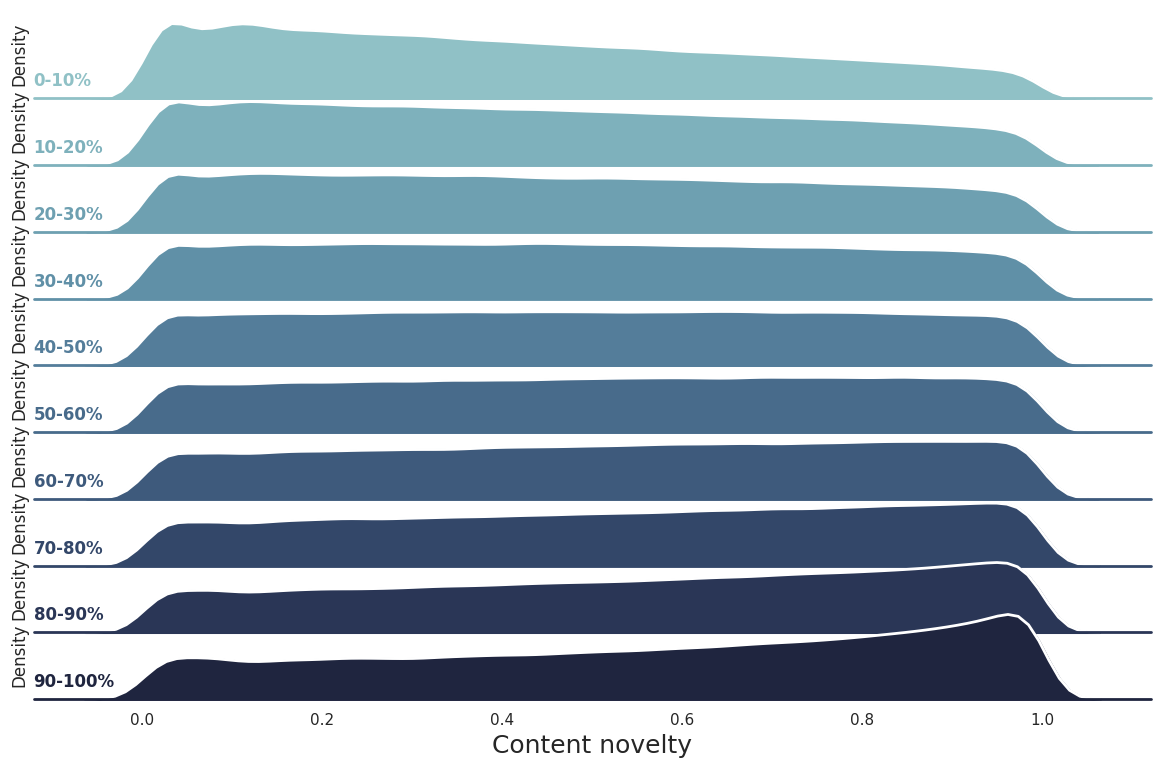

In [65]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(content, row="X", hue="X", aspect=15, height=.8, palette=pal);
g.map(sns.kdeplot, "Y",
      bw_adjust=1., clip_on=False,
      fill=True, alpha=1, linewidth=1.5, gridsize=100)
g.map(sns.kdeplot, "Y", clip_on=False, color="w", lw=2, bw_adjust=1., gridsize=100)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
def annotate(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, x.unique()[0], fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(annotate, "bin")
g.fig.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set_xlabels("Content novelty", fontsize=18);
g.set(yticks=[])
g.despine(bottom=True, left=True);

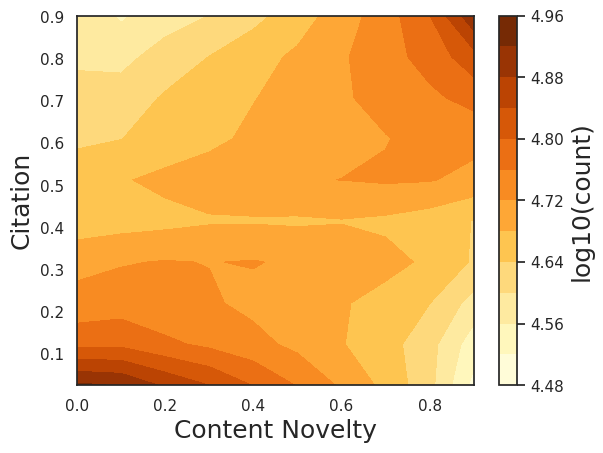

In [68]:
# Generate histogram data
H, xbins, ybins = np.histogram2d(content['Y'], content['Z'], [10, 10])
x, y = np.meshgrid(xbins[:-1], ybins[:-1])

# Plot the data
plt.contourf(x, y, np.log10(H.T), 10, cmap="YlOrBr")

# Add colorbar with automatic tick handling
cbar = plt.colorbar()
cbar.ax.set_ylabel('log10(count)', fontsize=18)

# Optionally, set log scale for the colorbar (uncomment if needed)
# cbar.ax.set_yscale('log')

plt.xlabel('Content Novelty', fontsize=18)
plt.ylabel('Citation', fontsize=18)
plt.show()

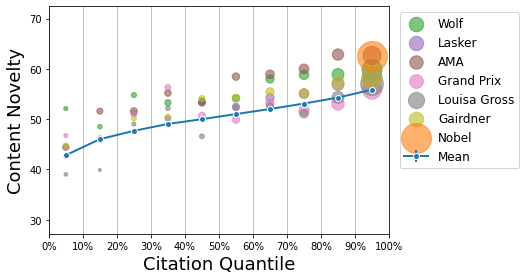

In [99]:
fig,ax=plt.subplots(figsize=(8,4))
ax.errorbar(content_agg['X'],
            content_agg['Y']['mean'],
            fmt='o-',lw=2, mec='w', mew=1, label='Mean',
            yerr=1.96*content_agg['Y']['std']/np.sqrt(content_agg['Y']['len']),
            color='C0');

df2=award_content2[award_content2.prize.str.contains('Wolf Prize in Medicine')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C2',alpha=0.6, label='Wolf', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Lasker')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C4',alpha=0.6, label='Lasker', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('AMA')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C5',alpha=0.6, label='AMA', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Grand Prix')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C6',alpha=0.6, label='Grand Prix', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Louisa Gross')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C7',alpha=0.6, label='Louisa Gross', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Gairdner')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C8',alpha=0.6, label='Gairdner', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content[award_content['discipline']=='Medicine']\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C1',alpha=0.6, label='Nobel',
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);
plt.xticks(np.arange(0,11)-0.5,[str(i)+'%' for i in range(0,110,10)]);
plt.xlim([-0.5,9.5])
ax.grid(axis='x');
ax.set_ylim((27.20458169209319, 72.42481383847897));
plt.ylabel('Content Novelty',fontsize=18);
plt.xlabel('Citation Quantile',fontsize=18);
plt.legend(bbox_to_anchor=(1.4, 1),fontsize=12);
plt.tight_layout();

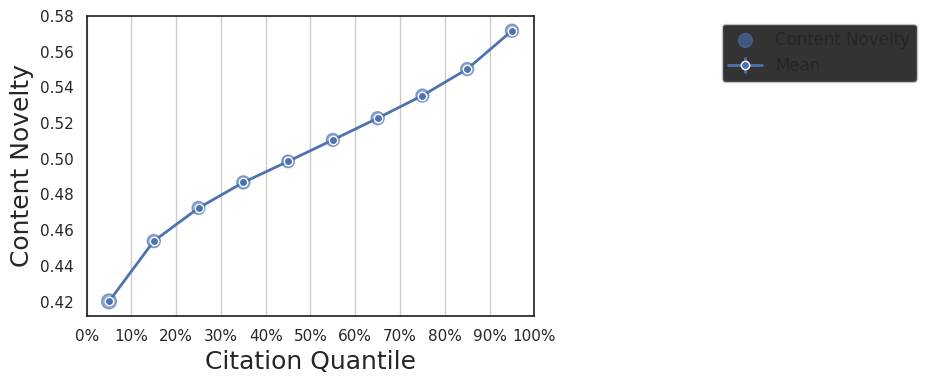

In [69]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the mean and error bars for content_agg
ax.errorbar(content_agg['X'],
            content_agg['Y']['mean'],
            fmt='o-', lw=2, mec='w', mew=1, label='Mean',
            yerr=1.96 * content_agg['Y']['std'] / np.sqrt(content_agg['Y']['len']),
            color='C0')

# Scatter plot with content_agg data
ax.scatter(content_agg['X'], content_agg['Y']['mean'], c='C0', alpha=0.6, label='Content Novelty',
           s=content_agg['Y']['len'] / content_agg['Y']['len'].sum() * 900)

# Customize ticks, labels, and layout
plt.xticks(np.arange(0, 11) - 0.5, [f'{i}%' for i in range(0, 110, 10)])
plt.xlim([-0.5, 9.5])
ax.grid(axis='x')
plt.ylabel('Content Novelty', fontsize=18)
plt.xlabel('Citation Quantile', fontsize=18)
plt.legend(bbox_to_anchor=(1.4, 1), fontsize=12)
plt.tight_layout()

plt.show()


In [70]:
%%time
X_j=[]
Y_j=[]
Z_j=[]
award_context=[]
award_context2=[]
for df in dfs[6:40]:
    df2=df.loc[df.refs>1,['ID','sJ','cites']].dropna()
    df2['bins']=pd.qcut(df2['cites'],10)
    df2['percent']=df2['bins'].cat.codes
    df2['nov']=-np.log(df2.sJ+1e-16)
    df2['nov']=(rankdata(df2['nov'])-1)/(len(df2)-1)
    df2['cites']=(rankdata(df2['cites'])-1)/(len(df2)-1)
    X_j.append(df2['bins'].cat.codes)
    Y_j.append(df2['nov'])
    Z_j.append(df2['cites'])
    # a=df2.merge(award_papers,left_on='ID',right_on='PMID')
    # a=a.sort_values('cites',ascending=False)
    # a=a.drop_duplicates('Laureate ID')
    # a=a.drop_duplicates('PMID')
    # award_context.append(a)
    # a=df2.merge(award_papers2,left_on='ID',right_on='pmid')
    # a=a.sort_values('cites',ascending=False)
    # award_context2.append(a)
X_j=np.hstack(X_j)
Y_j=np.hstack(Y_j)
Z_j=np.hstack(Z_j)
# award_context=pd.concat(award_context)
# award_context2=pd.concat(award_context2)

CPU times: user 1.3 s, sys: 8.04 ms, total: 1.31 s
Wall time: 1.31 s


In [71]:
context=pd.DataFrame({'X':X_j, 'Y':Y_j, 'Z':Z_j})
context_agg=context.groupby('X').agg([np.mean,np.std,len])
context["bin"]=context["X"].map(lambda x: "{}-{}%".format(x*10,(x+1)*10))
context_agg=context_agg.reset_index()

# award_context['nov']=award_context['nov']
# award_context2['nov']=award_context2['nov']

/tmp/ipykernel_465/463504265.py:2: FutureWarning: The provided callable <function mean at 0x7fbccc03f760> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  context_agg=context.groupby('X').agg([np.mean,np.std,len])
/tmp/ipykernel_465/463504265.py:2: FutureWarning: The provided callable <function std at 0x7fbccc03f880> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  context_agg=context.groupby('X').agg([np.mean,np.std,len])


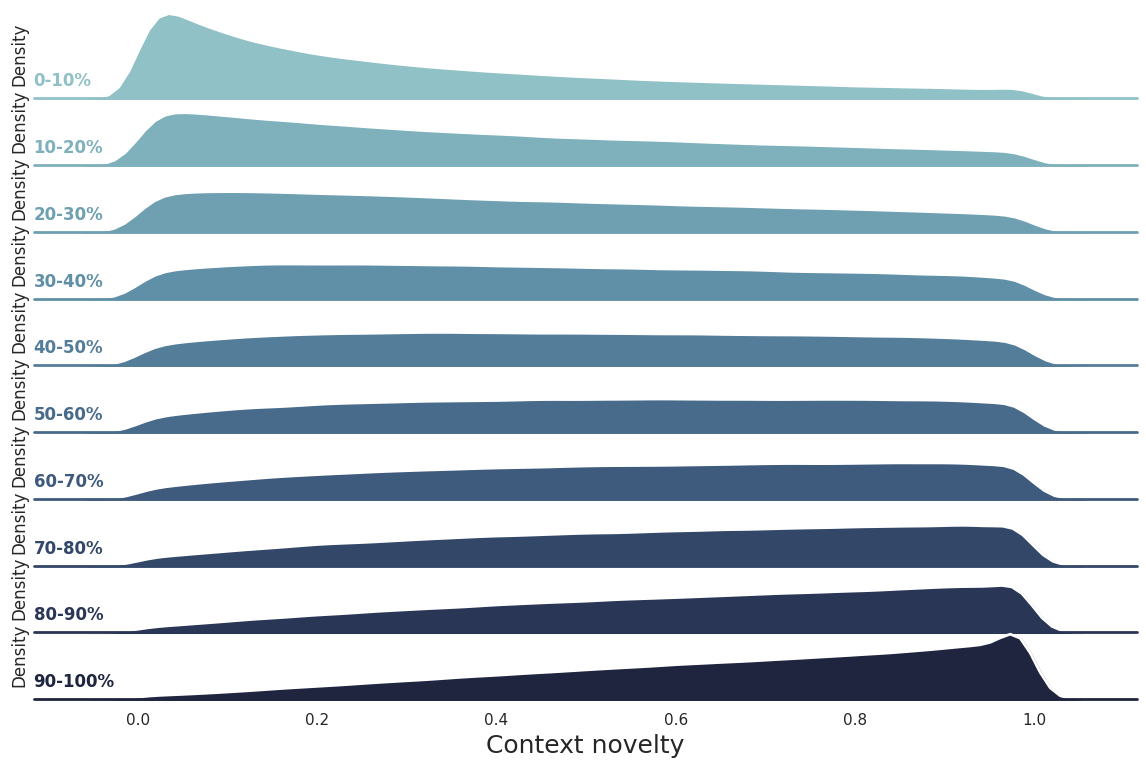

In [72]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(context, row="X", hue="X", aspect=15, height=.8, palette=pal);
g.map(sns.kdeplot, "Y",
      bw_adjust=1., clip_on=False,
      fill=True, alpha=1, linewidth=1.5, gridsize=100)
g.map(sns.kdeplot, "Y", clip_on=False, color="w", lw=2, bw_adjust=1., gridsize=100)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
def annotate(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, x.unique()[0], fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(annotate, "bin")
g.fig.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set_xlabels("Context novelty", fontsize=18);
g.set(yticks=[])
g.despine(bottom=True, left=True);

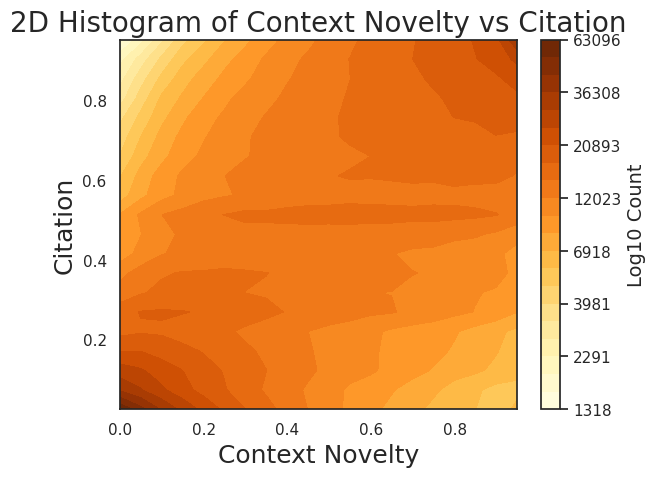

In [74]:
# Compute 2D histogram
H, xbins, ybins = np.histogram2d(context['Y'], context['Z'], bins=[20, 20])

# Create meshgrid for contour plotting
x, y = np.meshgrid(xbins[:-1], ybins[:-1])

# Plot contourf
plt.contourf(x, y, np.log10(H.T + 1e-6), 20, cmap="YlOrBr")  # Added a small constant to avoid log10(0)

# Add color bar with appropriate tick labels
cbar = plt.colorbar()
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)  # Set the ticks manually if necessary
cbar.set_label('Log10 Count', fontsize=14)
cbar.set_ticklabels([f'{10**tick:.0f}' for tick in ticks])

# Labels and other plot settings
plt.xlabel('Context Novelty', fontsize=18)
plt.ylabel('Citation', fontsize=18)
plt.title('2D Histogram of Context Novelty vs Citation', fontsize=20)
plt.grid(True)
plt.show()


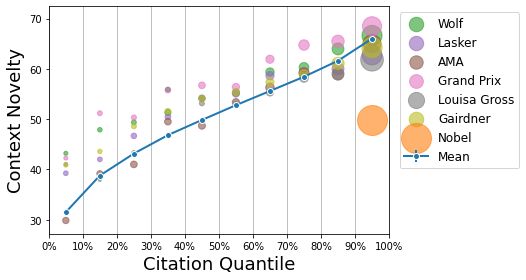

In [105]:
fig,ax=plt.subplots(figsize=(8,4))
ax.errorbar(context_agg['X'],
            context_agg['Y']['mean'],
            fmt='o-',lw=2, mec='w', mew=1, label='Mean',
            yerr=1.96*context_agg['Y']['std']/np.sqrt(context_agg['Y']['len']),
            color='C0');

df2=award_context2[award_context2.prize.str.contains('Wolf Prize in Medicine')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C2',alpha=0.6, label='Wolf', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Lasker')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C4',alpha=0.6, label='Lasker', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('AMA')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C5',alpha=0.6, label='AMA', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Grand Prix')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C6',alpha=0.6, label='Grand Prix', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Louisa Gross')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C7',alpha=0.6, label='Louisa Gross', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Gairdner')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C8',alpha=0.6, label='Gairdner', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context[award_context['discipline']=='Medicine']\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C1',alpha=0.6, label='Nobel',
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);
plt.xticks(np.arange(0,11)-0.5,[str(i)+'%' for i in range(0,110,10)]);
plt.xlim([-0.5,9.5])
ax.grid(axis='x');
ax.set_ylim((27.20458169209319, 72.42481383847897));
plt.ylabel('Context Novelty',fontsize=18);
plt.xlabel('Citation Quantile',fontsize=18);
plt.legend(bbox_to_anchor=(1.4, 1),fontsize=12);
plt.tight_layout();

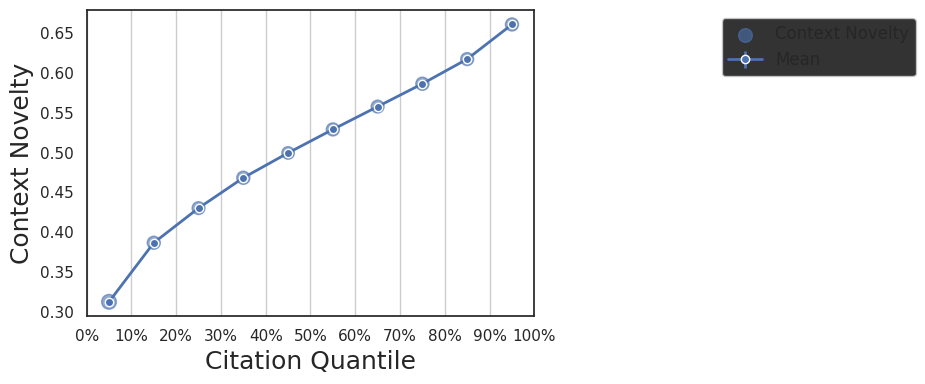

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the mean and error bars for context_agg
ax.errorbar(context_agg['X'],
            context_agg['Y']['mean'],
            fmt='o-', lw=2, mec='w', mew=1, label='Mean',
            yerr=1.96 * context_agg['Y']['std'] / np.sqrt(context_agg['Y']['len']),
            color='C0')

# Scatter plot with context_agg data
ax.scatter(context_agg['X'], context_agg['Y']['mean'], c='C0', alpha=0.6, label='Context Novelty',
           s=context_agg['Y']['len'] / context_agg['Y']['len'].sum() * 900)

# Customize ticks, labels, and layout
plt.xticks(np.arange(0, 11) - 0.5, [f'{i}%' for i in range(0, 110, 10)])
plt.xlim([-0.5, 9.5])
ax.grid(axis='x')
plt.ylabel('Context Novelty', fontsize=18)
plt.xlabel('Citation Quantile', fontsize=18)
plt.legend(bbox_to_anchor=(1.4, 1), fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


In [76]:
pearsonr(context_agg['X'], context_agg['Y']['mean'])

PearsonRResult(statistic=np.float64(0.9905562798616223), pvalue=np.float64(3.440490206534516e-08))

### Citation vs novelty

In [82]:
%%time
X_m=[]
Y_m=[]
award_content=[]
award_content2=[]
for df in dfs[6:40]:
    df2=df.loc[df.refs>1,['ID','sM','cites']].dropna()
    df2['nov']=-np.log(df2.sM)
    df2['bins']=pd.qcut(df2['nov'],10)
    df2['percent']=df2['bins'].cat.codes
#     df2["cites"]=np.log(df2['cites']+1)
    df2['cites']=(rankdata(df2['cites'])-1)/(len(df2)-1)
    X_m.append(df2['bins'].cat.codes)
    Y_m.append(df2['cites'])
#     a=df2.merge(award_papers,left_on='ID',right_on='PMID')
#     a=a.sort_values('cites',ascending=False)
#     a=a.drop_duplicates('Laureate ID')
#     a=a.drop_duplicates('PMID')
#     award_content.append(a)
#     a=df2.merge(award_papers2,left_on='ID',right_on='pmid')
#     a=a.sort_values('cites',ascending=False)
# #     a=a.drop_duplicates('author_id')
#     award_content2.append(a)
X_m=np.hstack(X_m)
Y_m=np.hstack(Y_m)

CPU times: user 948 ms, sys: 7.82 ms, total: 956 ms
Wall time: 955 ms


In [83]:
content=pd.DataFrame({'X':X_m, 'Y':Y_m})
content_agg=content.groupby('X').agg([np.mean,np.std,len])
content_agg=content_agg.reset_index()

# award_content=pd.concat(award_content)
# award_content2=pd.concat(award_content2)

/tmp/ipykernel_465/3787241325.py:2: FutureWarning: The provided callable <function mean at 0x7fbccc03f760> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  content_agg=content.groupby('X').agg([np.mean,np.std,len])
/tmp/ipykernel_465/3787241325.py:2: FutureWarning: The provided callable <function std at 0x7fbccc03f880> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  content_agg=content.groupby('X').agg([np.mean,np.std,len])


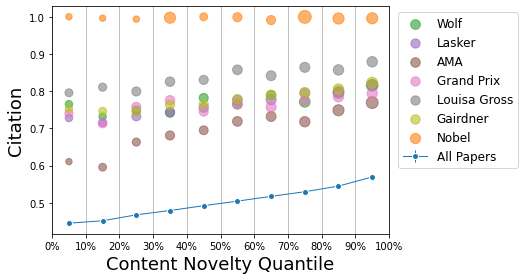

In [83]:
fig,ax=plt.subplots(figsize=(8,4))
ax.errorbar(content_agg['X'],
            content_agg['Y']['mean'],
            fmt='o-',lw=1, mec='w', mew=1, label='All Papers',
            yerr=1.96*content_agg['Y']['std']/np.sqrt(content_agg['Y']['len']),
            color='C0');

df2=award_content2[award_content2.prize.str.contains('Wolf Prize in Medicine')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C2',alpha=0.6, label='Wolf', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Lasker')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C4',alpha=0.6, label='Lasker', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('AMA')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C5',alpha=0.6, label='AMA', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Grand Prix')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C6',alpha=0.6, label='Grand Prix', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Louisa Gross')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C7',alpha=0.6, label='Louisa Gross', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Gairdner')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C8',alpha=0.6, label='Gairdner', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content[award_content['discipline']=='Medicine']\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C1',alpha=0.6, label='Nobel',
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

plt.xticks(np.arange(0,11)-0.5,[str(i)+'%' for i in range(0,110,10)]);
plt.xlim([-0.5,9.5])
ax.grid(axis='x');
# ax.set_ylim((27.20458169209319, 72.42481383847897));
plt.xlabel('Content Novelty Quantile',fontsize=18);
plt.ylabel('Citation',fontsize=18);
plt.legend(bbox_to_anchor=(1.4, 1),fontsize=12);
plt.tight_layout();
# plt.savefig("../Figures/medline_content_awards.pdf");

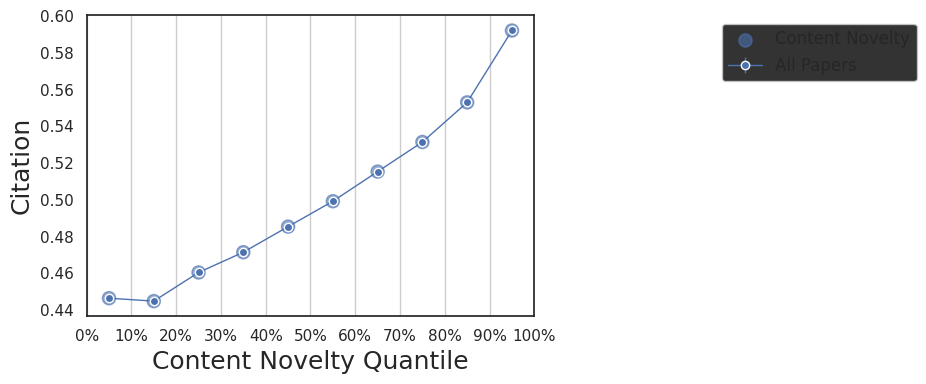

In [85]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the mean and error bars for content_agg
ax.errorbar(content_agg['X'],
            content_agg['Y']['mean'],
            fmt='o-', lw=1, mec='w', mew=1, label='All Papers',
            yerr=1.96 * content_agg['Y']['std'] / np.sqrt(content_agg['Y']['len']),
            color='C0')

# Scatter plot with content_agg data
ax.scatter(content_agg['X'], content_agg['Y']['mean'], c='C0', alpha=0.6, label='Content Novelty',
           s=content_agg['Y']['len'] / content_agg['Y']['len'].sum() * 900)


# Customize ticks, labels, and layout
plt.xticks(np.arange(0, 11) - 0.5, [f'{i}%' for i in range(0, 110, 10)])
plt.xlim([-0.5, 9.5])
ax.grid(axis='x')
plt.xlabel('Content Novelty Quantile', fontsize=18)
plt.ylabel('Citation', fontsize=18)
plt.legend(bbox_to_anchor=(1.4, 1), fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [106]:
%%time
X=[]
Y=[]
award_context=[]
award_context2=[]
for df in dfs[6:40]:
    df2=df.loc[df.refs>1,['ID','sJ','cites']].dropna()
    df2['nov']=-np.log(df2.sJ+1e-16)
    df2['bins']=pd.qcut(df2['nov'],10)
    df2['percent']=df2['bins'].cat.codes
#     df2["cites"]=np.log(df2['cites']+1)
    df2['cites']=(rankdata(df2['cites'])-1)/(len(df2)-1)
    X.append(df2['bins'].cat.codes)
    Y.append(df2['cites'])
#     a=df2.merge(award_papers,left_on='ID',right_on='PMID')
#     a=a.sort_values('cites',ascending=False)
#     a=a.drop_duplicates('Laureate ID')
#     a=a.drop_duplicates('PMID')
#     award_context.append(a)
#     a=df2.merge(award_papers2,left_on='ID',right_on='pmid')
#     a=a.sort_values('cites',ascending=False)
# #     a=a.drop_duplicates('author_id')
#     award_context2.append(a)
X=np.hstack(X)
Y=np.hstack(Y)

CPU times: user 31.9 s, sys: 2.31 s, total: 34.2 s
Wall time: 7.58 s


In [107]:
context=pd.DataFrame({'X':X, 'Y':Y})
context_agg=context.groupby('X').agg([np.mean,np.std,len])
context_agg=context_agg.reset_index()

award_context=pd.concat(award_context)
award_context2=pd.concat(award_context2)

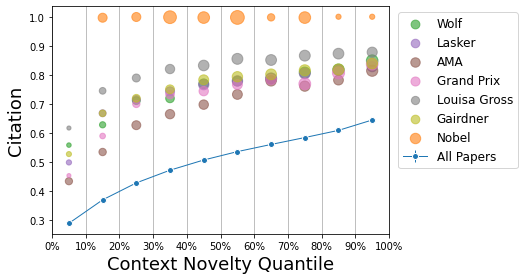

In [110]:
fig,ax=plt.subplots(figsize=(8,4))
ax.errorbar(context_agg['X'],
            context_agg['Y']['mean'],
            fmt='o-',lw=1, mec='w', mew=1, label='All Papers',
            yerr=1.96*context_agg['Y']['std']/np.sqrt(context_agg['Y']['len']),
            color='C0');

df2=award_context2[award_context2.prize.str.contains('Wolf Prize in Medicine')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C2',alpha=0.6, label='Wolf', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Lasker')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C4',alpha=0.6, label='Lasker', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('AMA')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C5',alpha=0.6, label='AMA', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Grand Prix')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C6',alpha=0.6, label='Grand Prix', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Louisa Gross')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C7',alpha=0.6, label='Louisa Gross', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Gairdner')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C8',alpha=0.6, label='Gairdner', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context[award_context['discipline']=='Medicine']\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C1',alpha=0.6, label='Nobel',
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

plt.xticks(np.arange(0,11)-0.5,[str(i)+'%' for i in range(0,110,10)]);
plt.xlim([-0.5,9.5])
ax.grid(axis='x');
# ax.set_ylim((27.20458169209319, 72.42481383847897));
plt.xlabel('Context Novelty Quantile',fontsize=18);
plt.ylabel('Citation',fontsize=18);
plt.legend(bbox_to_anchor=(1.4, 1),fontsize=12);
plt.tight_layout();
# plt.savefig("../Figures/medline_content_awards.pdf");